# Analyzing customer service calls
This notebook provides sample [EDSL](https://docs.expectedparrot.com/) code for conducting an analysis of textual content with AI agents and large language models. Using a set of transcripts of mock customer calls as an example, we use EDSL to prompt an AI agent to identify the callers' names, emails, questions and requests and return the results as a formatted dataset. The code is readily editable for reviewing other content, giving the agent different personas, and prompting the agent to extract other information.

## Technical setup
Before running the code below, please ensure that you have [installed the EDSL libary](https://docs.expectedparrot.com/en/latest/installation.html) and either [activated remote inference](https://docs.expectedparrot.com/en/latest/remote_inference.html) from your [Coop account](https://docs.expectedparrot.com/en/latest/coop.html) or [stored API keys](https://docs.expectedparrot.com/en/latest/api_keys.html) for the language models that you want to use with EDSL. Please also see our [documentation page](https://docs.expectedparrot.com/) for tips and tutorials on getting started using EDSL.

## Constructing questions about the data
We start by constructing questions about the content we want to analyze. 
[EDSL comes with a variety of question types](https://docs.expectedparrot.com/en/latest/questions.html) that we can choose from based on the form of the response that we want to get back from the model (multiple choice, linear scale, free text, etc.). 
Here we use `QuestionFreeText` to get the caller names and emails and `QuestionList` to list out any questions and requests of the callers, with a `{{ placeholder }}` for a transcript:

In [1]:
from edsl import QuestionFreeText, QuestionList

# Construct questions in the relevant question type templates
# Use a placeholder for the transcripts to be reviewed
q_name = QuestionFreeText(
    question_name="name",
    question_text="""
    What is caller's name? Transcript: {{ transcript }}
    Return just the name of the caller.
    """,
)

q_email = QuestionFreeText(
    question_name="email",
    question_text="""What is caller's email address? Transcript: {{ transcript }}
    Return just the email address.
    """,
)

q_questions = QuestionList(
    question_name="questions",
    question_text="What questions does the caller have? Transcript: {{ transcript }}?",
)

q_requests = QuestionList(
    question_name="requests",
    question_text="What is the caller requesting? Transcript: {{ transcript }}?",
)

## Creating a survey
We combine the questions into a `Survey` in order to administer them all together:

In [2]:
from edsl import Survey

survey = Survey([q_name, q_email, q_questions, q_requests])

## Adding context to questions
Next we import a dataset of transcripts to add to the questions, creating a `Scenario` dictionary for each transcript. 
[EDSL provides methods for importing content from many different data sources](https://docs.expectedparrot.com/en/latest/scenarios.html), including PDFs, CSVs, docs, images, tables, lists, dicts, etc. 
Here we use a CSV of texts, [retrieved from the Coop](https://www.expectedparrot.com/content/01474c60-d02b-4874-a577-953e870d8bff):

In [3]:
from edsl.scenarios.FileStore import CSVFileStore

csv_file = CSVFileStore.pull('01474c60-d02b-4874-a577-953e870d8bff', expected_parrot_url='https://www.expectedparrot.com')

In [4]:
from edsl import ScenarioList, Scenario

scenarios = ScenarioList.from_csv(csv_file.to_tempfile()) 

We can inspect the scenarios ([and rename or edit them as desired](https://docs.expectedparrot.com/en/latest/scenarios.html)):

In [5]:
scenarios

ScenarioList([Scenario({'transcript': '"Agent: Good morning, thank you for calling Renovation Software Solutions. How can I assist you today? Customer: Hi, I\'m having trouble with the 3D rendering feature. It seems to crash every time I try to add a new room. Agent: I\'m sorry to hear that. Let me check if there are any known issues with the 3D rendering feature. Can you tell me which version of the software you\'re using? Customer: I\'m using version 5.3.2 on a Windows 10 PC. Agent: Thank you. There was a recent update that might resolve this issue. Please make sure your software is updated to the latest version. If the problem persists, we can arrange a remote support session to troubleshoot further. Could I have your name and email address to send you further instructions? Customer: Sure, it\'s Emily Davis, emily.davis@example.com. Agent: Great, I\'ll send the instructions to your email. I\'ll update the software and try again. If it still crashes, I\'ll call back. Thanks for your help. Agent: You\'re welcome. Have a great day! [Caller sounded frustrated]",'}), Scenario({'transcript': '"Agent: Good afternoon, Renovation Software Solutions. How may I help you? Customer: Hi, I\'m looking for a tutorial on how to use the budget tracking feature. Is there a video or a guide available? Agent: Yes, we have several resources available. You can find tutorial videos and step-by-step guides on our website under the \'Support\' section. If you need further assistance, we can also schedule a live demo with one of our specialists. Could I get your name and email address to send you the details? Customer: That sounds perfect. My name is Sarah Johnson, and my email is sarah.johnson@example.com. Agent: Thank you, Sarah. I\'ll send you the details shortly. Have a great day! Customer: Thank you! Agent: My pleasure. Have a great day! [Caller sounded satisfied]",'}), Scenario({'transcript': '"Agent: Hello, thank you for calling Renovation Software Solutions. How can I assist you today? Customer: Hi, I need help with my account. I can\'t seem to reset my password, and I\'m locked out. Agent: I\'m sorry to hear that. Let\'s get that sorted out. Can you provide me with your email address associated with the account? Customer: Sure, it\'s mike.thomas@example.com. Agent: And may I have your name, please? Customer: Mike Thomas. Agent: Thank you, Mike. I\'ll send you a password reset link. Please check your email and follow the instructions. If you don\'t receive the email within a few minutes, check your spam folder or give us a call back. Customer: Got it. I\'ll keep an eye out for the email. Thanks for your help. Agent: You\'re welcome. Have a great day!",'}), Scenario({'transcript': '"Agent: Good morning, Renovation Software Solutions. How may I help you today? Customer: Hi, I\'m interested in upgrading my subscription plan. What are the options available? Agent: We offer several subscription plans to suit different needs. Our standard plan includes basic features, while our premium plan includes advanced tools and priority support. You can find detailed information on our website or I can email you a comparison chart. Customer: Please email me the comparison chart. My email is laura.miller@example.com. Agent: Certainly. Could I get your name as well? Customer: Laura Miller. Agent: Thank you, Laura. I\'ll send that over right away. If you have any questions after reviewing it, feel free to contact us. Customer: Will do. Thanks a lot! Agent: You\'re welcome. Have a great day!",'}), Scenario({'transcript': '"Agent: Good afternoon, thank you for calling Renovation Software Solutions. How can I help you today? Customer: Hi, I\'m having an issue with exporting my project to PDF. The file seems to be corrupted every time I try. Agent: I\'m sorry to hear that. Can you tell me which version of the software you\'re using and the operating system? Customer: I\'m using version 5.3.2 on macOS. Agent: Thank you. This issue can sometimes be resolved by updati

## Designing an AI agent to answer the survey
We can create a persona for an AI `Agent` that a language model will use to answer the questions, and give it instructions on the task:

In [6]:
from edsl import Agent

agent = Agent(
    traits={"persona": "Customer service agent"},
    instruction="You are answering questions about transcripts of customer service calls.",
)

## Selecting a language model
We can select one or more specific models to generate the responses.
(If no model is specified, GPT 4 preview is used by default).

To see a list of all available models:

In [7]:
from edsl import Model

# Model.available()

Here we select a model:

In [8]:
model = Model("gpt-4o")

## Getting responses
We generate responses by adding the scenarios, agent and model to the survey and then calling the `run()` method:

In [9]:
results = survey.by(scenarios).by(agent).by(model).run()

This generates a dataset of `Results` that we can begin analyzing. 
EDSL comes with [built-in methods for analyzing results](https://docs.expectedparrot.com/en/latest/results.html).
For example, we can print the responses in a table:

In [10]:
results.select("name", "email", "questions", "requests").print(format="rich")

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ answer        ┃ answer                    ┃ answer                           ┃ answer                           ┃
┃ .name         ┃ .email                    ┃ .questions                       ┃ .requests                        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Emily Davis   │ emily.davis@example.com   │ ["I'm having trouble with the 3D │ ['Troubleshooting the 3D         │
│               │                           │ rendering feature. It seems to   │ rendering feature', 'Updating    │
│               │                           │ crash every time I try to add a  │ the software', 'Remote support   │
│               │                           │ new room.", "Can you tell me     │ session instructions']           │
│               │                           │ which version of the software    │                                  │
│               │                           │ you're using?", 'Could I have    │                                  │
│               │                           │ your name and email address to   │                                  │
│               │                           │ send you further instructions?'] │                                  │
├───────────────┼───────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│ Sarah Johnson │ sarah.johnson@example.com │ ['Is there a video or a guide    │ ['a tutorial on how to use the   │
│               │                           │ available?']                     │ budget tracking feature']        │
├───────────────┼───────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│ Mike Thomas   │ mike.thomas@example.com   │ ['I need help with my account',  │ ['reset his password', 'get back │
│               │                           │ "I can't seem to reset my        │ into his account']               │
│               │                           │ password", "I'm locked out"]     │                                  │
├───────────────┼───────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│ Laura Miller  │ laura.miller@example.com  │ ['What are the options available │ ['upgrading subscription plan',  │
│               │                           │ for upgrading my subscription    │ 'comparison chart via email']    │
│               │                           │ plan?']                          │                                  │
├───────────────┼───────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│ Jason Lee     │ jason.lee@example.com     │ ["Hi, I'm having an issue with   │ ['Exporting project to PDF       │
│               │                           │ exporting my project to PDF. The │ issue', 'Software version and    │
│               │                           │ file seems to be corrupted every │ operating system details', 'Name │
│               │                           │ time I try."]                    │ and email address for            │
│               │                           │                                  │ follow-up']                      │
├───────────────┼───────────────────────────┼──────────────────────────────────┼──────────────────────────────────┤
│ Olivia Brown  │ olivia.brown@example.com  │ ['Can multiple users work on the │ ['If multiple users can work on  │
│               │                           │ same project simultaneously?',   │ the same project                 │
│               │                           │ 'How do I invite team members to │ simultaneously', 'How to invite  │
│               │                           │ my project?']                    │ team members to the project']    │
├───────────────┼───────────────────────────┼───────────

## Quantifying responses
We can use the lists of caller questions and requests to quantify them (how often do they appear in the calls?). We start by prompting an agent to synthesize the lists into comprehensive lists that we can use as question options for new questions:

In [11]:
caller_questions = results.select("questions").to_list(flatten=True)
len(caller_questions)

22

In [12]:
caller_requests = results.select("requests").to_list(flatten=True)
len(caller_requests)

24

In [13]:
q_condense = QuestionList(
    question_name="condense",
    question_text="""
    You have reviewed a set of call transcripts and compiled a detailed list of {{ topic }}. 
    Now you are being asked to condense this list into a more generalized but comprehensive 
    list that can be used to quanitfy the {{ topic }} efficiently (i.e., combine like items 
    on the list). Here is the list to be condensed: {{ list }}
    """,
    max_list_items=10,  # Optional
)

scenarios = ScenarioList([
    Scenario({"topic": "caller questions", "list": caller_questions}),
    Scenario({"topic": "caller requests", "list": caller_requests}),
])

condensed_lists = q_condense.by(scenarios).run()

In [14]:
condensed_lists.select("topic", "condense").print(format="rich")

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario         ┃ answer                                                                                       ┃
┃ .topic           ┃ .condense                                                                                    ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ caller questions │ ['Technical issues with features', 'Account access and password issues', 'Subscription and   │
│                  │ upgrade options', 'Project export problems', 'Collaboration and team management', 'Cost      │
│                  │ estimation and calibration', 'Guides and instructional resources', 'General account          │
│                  │ assistance', 'Feature suggestions and feedback', 'Trial period inquiries']                   │
├──────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────┤
│ caller requests  │ ['Technical Support', 'Account Access', 'Subscription and Trial Information', 'Software      │
│                  │ Updates', 'Feature Tutorials', 'Project Management Tools', 'User Collaboration', 'Export and │
│                  │ Synchronization Issues', 'Follow-Up Information', 'Cost Estimation']                         │
└──────────────────┴──────────────────────────────────────────────────────────────────────────────────────────────┘

We can use the condensed lists as options for new questions quantifying the topics:

In [15]:
condensed_questions = (
    condensed_lists.filter("topic == 'caller questions'").select("condense").first()
)
condensed_questions

['Technical issues with features',
 'Account access and password issues',
 'Subscription and upgrade options',
 'Project export problems',
 'Collaboration and team management',
 'Cost estimation and calibration',
 'Guides and instructional resources',
 'General account assistance',
 'Feature suggestions and feedback',
 'Trial period inquiries']

In [16]:
condensed_requests = (
    condensed_lists.filter("topic == 'caller requests'").select("condense").first()
)
condensed_requests

['Technical Support',
 'Account Access',
 'Subscription and Trial Information',
 'Software Updates',
 'Feature Tutorials',
 'Project Management Tools',
 'User Collaboration',
 'Export and Synchronization Issues',
 'Follow-Up Information',
 'Cost Estimation']

In [17]:
from edsl import QuestionCheckBox

q_questions_agg = QuestionCheckBox(
    question_name="questions_agg",
    question_text="""
    Review the following call transcript and then identify the topic(s)
    that the caller has questions about. Transcript: {{ transcript }}
    """,
    question_options=condensed_questions + ["Something else", "None of these"],
)

q_requests_agg = QuestionCheckBox(
    question_name="requests_agg",
    question_text="""
    Review the following call transcript and then identify the topic(s)
    that the caller has requests about. Transcript: {{ transcript }}
    """,
    question_options=condensed_requests + ["Something else", "None of these"],
)

survey = Survey([q_questions_agg, q_requests_agg])

We can use the results of the initial survey as scenarios of our follow-on questions. The `to_scenario_list()` method lets us do this in a single step:

In [18]:
scenarios = results.select("name", "email", "transcript").to_scenario_list(
    remove_prefix=True
)
scenarios[0]

Scenario({'name': 'Emily Davis', 'email': 'emily.davis@example.com', 'transcript': '"Agent: Good morning, thank you for calling Renovation Software Solutions. How can I assist you today? Customer: Hi, I\'m having trouble with the 3D rendering feature. It seems to crash every time I try to add a new room. Agent: I\'m sorry to hear that. Let me check if there are any known issues with the 3D rendering feature. Can you tell me which version of the software you\'re using? Customer: I\'m using version 5.3.2 on a Windows 10 PC. Agent: Thank you. There was a recent update that might resolve this issue. Please make sure your software is updated to the latest version. If the problem persists, we can arrange a remote support session to troubleshoot further. Could I have your name and email address to send you further instructions? Customer: Sure, it\'s Emily Davis, emily.davis@example.com. Agent: Great, I\'ll send the instructions to your email. I\'ll update the software and try again. If it still crashes, I\'ll call back. Thanks for your help. Agent: You\'re welcome. Have a great day! [Caller sounded frustrated]",'})

In [19]:
agg_results = survey.by(scenarios).by(agent).run()

In [20]:
agg_results.columns

['agent.agent_instruction',
 'agent.agent_name',
 'agent.persona',
 'answer.questions_agg',
 'answer.requests_agg',
 'comment.questions_agg_comment',
 'comment.requests_agg_comment',
 'generated_tokens.questions_agg_generated_tokens',
 'generated_tokens.requests_agg_generated_tokens',
 'iteration.iteration',
 'model.frequency_penalty',
 'model.logprobs',
 'model.max_tokens',
 'model.model',
 'model.presence_penalty',
 'model.temperature',
 'model.top_logprobs',
 'model.top_p',
 'prompt.questions_agg_system_prompt',
 'prompt.questions_agg_user_prompt',
 'prompt.requests_agg_system_prompt',
 'prompt.requests_agg_user_prompt',
 'question_options.questions_agg_question_options',
 'question_options.requests_agg_question_options',
 'question_text.questions_agg_question_text',
 'question_text.requests_agg_question_text',
 'question_type.questions_agg_question_type',
 'question_type.requests_agg_question_type',
 'raw_model_response.questions_agg_cost',
 'raw_model_response.questions_agg_one_us

In [21]:
agg_results.select("questions_agg", "requests_agg").print(format="rich")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ answer                                                 ┃ answer                                                 ┃
┃ .questions_agg                                         ┃ .requests_agg                                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ['Technical issues with features']                     │ ['Technical Support', 'Software Updates', 'Follow-Up   │
│                                                        │ Information']                                          │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['Guides and instructional resources']                 │ ['Feature Tutorials']                                  │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['Account access and password issues']                 │ ['Technical Support', 'Account Access']                │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['Subscription and upgrade options']                   │ ['Subscription and Trial Information']                 │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['Technical issues with features', 'Project export     │ ['Technical Support', 'Export and Synchronization      │
│ problems']                                             │ Issues', 'Follow-Up Information']                      │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['Collaboration and team management']                  │ ['Feature Tutorials', 'User Collaboration']            │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['Technical issues with features', 'Cost estimation    │ ['Technical Support', 'Cost Estimation']               │
│ and calibration']                                      │                                                        │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['Technical issues with features', 'General account    │ ['Technical Support', 'Export and Synchronization      │
│ assistance']                                           │ Issues']                                               │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['Feature suggestions and feedback']                   │ ['Project Management Tools', 'Something else']         │
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────┤
│ ['Trial period inquiries']                             │ ['Subscription and Trial Information']                 │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

## Visualizations
We can turn the results into a dataframe and inspect the totals:

In [22]:
import matplotlib.pyplot as plt
import ast

In [23]:
df = agg_results.to_pandas(remove_prefix=True)

In [24]:
# Convert the string representations of lists to actual lists
df["questions_agg"] = df["questions_agg"].apply(ast.literal_eval)
df["requests_agg"] = df["requests_agg"].apply(ast.literal_eval)

# Explode the lists into individual rows
questions_exploded = df.explode("questions_agg")
requests_exploded = df.explode("requests_agg")

# Count the frequency of each item
questions_counts = questions_exploded["questions_agg"].value_counts().reset_index()
questions_counts.columns = ["Question", "Count"]

requests_counts = requests_exploded["requests_agg"].value_counts().reset_index()
requests_counts.columns = ["Request", "Count"]

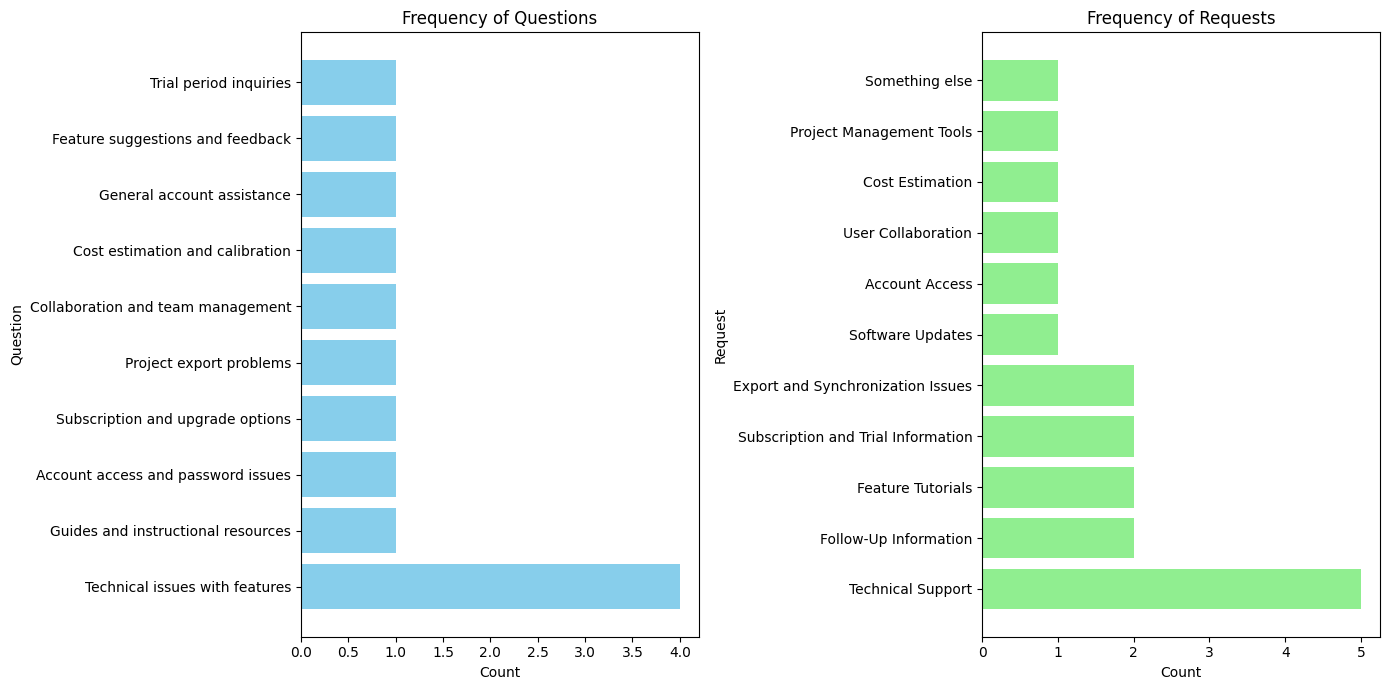

In [25]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Bar plot for questions
axes[0].barh(questions_counts["Question"], questions_counts["Count"], color="skyblue")
axes[0].set_title("Frequency of Questions")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Question")

# Bar plot for requests
axes[1].barh(requests_counts["Request"], requests_counts["Count"], color="lightgreen")
axes[1].set_title("Frequency of Requests")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Request")

plt.tight_layout()
plt.show()

In [26]:
# Display the counts
print("Questions Count Table:")
print(questions_counts)

print("\nRequests Count Table:")
print(requests_counts)

Questions Count Table:
                             Question  Count
0      Technical issues with features      4
1  Guides and instructional resources      1
2  Account access and password issues      1
3    Subscription and upgrade options      1
4             Project export problems      1
5   Collaboration and team management      1
6     Cost estimation and calibration      1
7          General account assistance      1
8    Feature suggestions and feedback      1
9              Trial period inquiries      1

Requests Count Table:
                               Request  Count
0                    Technical Support      5
1                Follow-Up Information      2
2                    Feature Tutorials      2
3   Subscription and Trial Information      2
4    Export and Synchronization Issues      2
5                     Software Updates      1
6                       Account Access      1
7                   User Collaboration      1
8                      Cost Estimation      1

## Exporting results
We can export the results as a CSV:

In [27]:
agg_results.to_csv("customer_calls_analysis.csv")

Please see our [documentation page](https://docs.expectedparrot.com/) for examples of other methods and use cases!

## Posting content to the Coop

In [28]:
from edsl import Notebook

In [29]:
n = Notebook(path = "summarizing_transcripts.ipynb")

In [30]:
n.push(description = "Example code for summarizing transcripts", visibility = "public")

{'description': 'Example code for summarizing transcripts',
 'object_type': 'notebook',
 'url': 'https://www.expectedparrot.com/content/a5cd8b20-b4d6-4856-95a9-90076ec36682',
 'uuid': 'a5cd8b20-b4d6-4856-95a9-90076ec36682',
 'version': '0.1.33.dev1',
 'visibility': 'public'}

Updating content at the Coop:

In [31]:
n = Notebook(path = "summarizing_transcripts.ipynb") # resave

In [32]:
n.patch(uuid = "a5cd8b20-b4d6-4856-95a9-90076ec36682", value = n)

{'status': 'success'}